<a href="https://colab.research.google.com/github/CaruntuRazvan/SNN-MNIST/blob/main/SNN_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Spiking Neural Networks (SNNs) - Introducere

Rețelele neuronale spiking (SNNs) reprezintă o clasă de modele inspirate biologic, care imită mai realist modul în care neuronii din creier procesează informația. Spre deosebire de rețelele neuronale clasice, care folosesc valori continue, SNN-urile transmit date prin impulsuri discrete de tip "spike" – similare semnalelor neuronale reale.

## 🔬 Ce este un spike?

Un "spike" este un impuls electric care apare atunci când potențialul de membrană al unui neuron atinge un prag critic. Într-o rețea SNN, fiecare neuron acumulează semnale de la alți neuroni și emite un spike doar dacă suma acestor semnale este suficient de mare.

## ⚙️ Cum funcționează un SNN?

- Neuronii au un potențial intern (membrane potential).
- Informația este transmisă doar când acest potențial atinge un prag → se generează un spike.
- Modele populare de neuroni: **LIF (Leaky Integrate-and-Fire)**, **IF (Integrate-and-Fire)**.
- Informația este codificată în **momentul** în care apare spike-ul, nu doar în intensitatea semnalului.

## 💡 De ce să folosim SNN-uri?

| Avantaje                     | Limitări                         |
|------------------------------|----------------------------------|
| Eficiență energetică         | Mai greu de antrenat             |
| Inspirație biologică         | Lipsa unor framework-uri mature |
| Compatibile cu hardware neuromorfic | Necesită encoding special |

## 🧪 Ce facem în acest notebook

În acest notebook vom construi și antrena un model simplu SNN folosind biblioteca `SpikingJelly`. Vom folosi setul de date MNIST (imagini cu cifre scrise de mână), vom codifica imaginile în spike-uri și vom învăța rețeaua să le clasifice.

---

✅ Scopul este să demonstrăm că rețelele spiking pot fi folosite pentru sarcini clasice de clasificare, cu rezultate surprinzător de bune, chiar și cu un model simplu.




Importăm bibliotecile necesare, inclusiv SpikingJelly pentru rețelele spiking. De asemenea, alegem automat dacă folosim CPU sau GPU pentru antrenare. Definim și time_window, care indică câți timesteps vor fi simulați pentru fiecare imagine în encoderul Poisson.

In [ ]:
!pip install spikingjelly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

# Secțiune nouă

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from spikingjelly.clock_driven import neuron, functional, encoding, surrogate
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
time_window = 20



Definim o clasă PoissonEncoderWrapper, care aplică codarea Poisson de time_steps ori unei imagini de intrare. Această codare transformă o imagine statică într-o secvență de spike-uri binare pe mai mulți timesteps, simulând cum funcționează neuronii biologici.

In [ ]:
class PoissonEncoderWrapper(nn.Module):
    def __init__(self, time_steps):
        super().__init__()
        self.encoder = encoding.PoissonEncoder()
        self.time_steps = time_steps

    def forward(self, x):
        encoded = [self.encoder(x) for _ in range(self.time_steps)]
        return torch.stack(encoded)



Creăm o rețea neuronală spiking SimpleSNN formată din:două straturi complet conectate (FC), două layere de neuroni LIF (Leaky Integrate-and-Fire), o funcție surrogate (sigmoid) care face neuroni derivabili pentru backpropagation. Modelul parcurge toți timesteps-ii codării Poisson și acumulează răspunsurile neuronale pentru a face predicția.



In [ ]:
class SimpleSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 100)
        self.sn1 = neuron.LIFNode(surrogate_function=surrogate.Sigmoid())
        self.fc2 = nn.Linear(100, 10)
        self.sn2 = neuron.LIFNode(surrogate_function=surrogate.Sigmoid())

    def forward(self, x):
        mem = 0
        for t in range(x.shape[0]):
            out = self.flatten(x[t])
            out = self.fc1(out)
            out = self.sn1(out)
            out = self.fc2(out)
            out = self.sn2(out)
            mem += out
        return mem / x.shape[0]


Folosim torchvision pentru a descărca și preprocesa datasetul MNIST. Imaginile sunt convertite în tensori și normalizate. Folosim un DataLoader pentru a crea batch-uri de date ce vor fi folosite la antrenare.



In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 52.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.25MB/s]


Instanțiem modelul SNN, encoderul Poisson, funcția de pierdere (CrossEntropy pentru clasificare multi-clasă) și optimizatorul Adam. Toate componentele sunt mutate pe dispozitivul disponibil (CPU sau GPU).

In [ ]:
model = SimpleSNN().to(device)
encoder = PoissonEncoderWrapper(time_window).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()


Pentru fiecare batch din dataset:

* Se aplică encoderul Poisson.

* Se face propagarea înainte prin rețea.

* Se calculează pierderea și se face optimizarea parametrilor.

* Se resetează stările interne ale neuronilor după fiecare batch.

* Se afișează loss-ul la fiecare 100 de batch-uri pentru urmărirea progresului.



In [ ]:
print("🚀 Începem antrenarea pe întregul dataset MNIST...")
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    encoded = encoder(data)
    out = model(encoded)
    loss = loss_fn(out, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    functional.reset_net(model)

    if batch_idx % 100 == 0:
        print(f"🔁 Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")
print("✅ Antrenare completă!")

🚀 Începem antrenarea pe întregul dataset MNIST...
🔁 Batch 0/469 - Loss: 2.3026
🔁 Batch 100/469 - Loss: 1.6480
🔁 Batch 200/469 - Loss: 1.5819
🔁 Batch 300/469 - Loss: 1.5940
🔁 Batch 400/469 - Loss: 1.5339
✅ Antrenare completă!


După finalizarea antrenării, salvăm greutățile modelului și encoderului într-un fișier .pth, pentru a putea fi încărcate ulterior în timpul inferenței sau pentru reantrenare.



In [ ]:
torch.save(model.state_dict(), 'snn_model.pth')
torch.save(encoder.state_dict(), 'snn_encoder.pth')
print("💾 Modelul și encoderul au fost salvate.")


💾 Modelul și encoderul au fost salvate.


🧪 Testarea modelului pe setul de testare MNIST
După finalizarea antrenării, evaluăm performanța modelului folosind datele de testare pentru a verifica cât de bine generalizează pe exemple nevăzute.

🔍 Ce face codul:
* Încarcă setul de testare MNIST și îl preprocesează la fel ca pe cel de antrenare (folosind transformările definite anterior).

* Trecem modelul în modul de evaluare (model.eval()), astfel încât să se dezactiveze comportamentele specifice antrenării, cum ar fi dropout-ul.

* Folosim torch.no_grad() pentru a opri calculul de gradient (nu avem nevoie de backpropagation în testare), ceea ce economisește memorie și accelerează rularea.

Pentru fiecare batch de imagini:

* Aplicăm encoderul Poisson pentru a genera spike-uri pe baza fiecărei imagini.

* Propagăm spike-urile prin rețea.

* Obținem predicția și o comparăm cu eticheta reală.

* Contorizăm câte predicții sunt corecte.

* Resetăm starea internă a neuronilor spiking cu functional.reset_net(model) pentru a evita interferența între batch-uri.

La final, calculăm și afișăm acuratețea totală ca procent de imagini clasificate corect.


In [ ]:
# 📦 Dataset de testare MNIST
test_dataset = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# 🔍 Evaluare acuratețe
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        encoded = encoder(data)
        outputs = model(encoded)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        functional.reset_net(model)

accuracy = 100 * correct / total
print(f"🎯 Acuratețea pe setul de testare MNIST: {accuracy:.2f}%")


🎯 Acuratețea pe setul de testare MNIST: 91.66%


# 🖥️ Interfață interactivă cu Streamlit pentru clasificarea MNIST folosind SNN

În această aplicație vom folosi o rețea neuronală spiking (SNN) antrenată pe MNIST pentru a crea o interfață interactivă cu utilizatorul. Scopul este să permitem testarea vizuală a modelului pe imagini reale din setul de test, într-un mod intuitiv și prietenos.

---

## ⚙️ Cum funcționează aplicația


1. 🔌 Încarcă modelul antrenat SNN (`SimpleSNN`) și encoderul Poisson.
2. 📦 Încarcă setul de date MNIST de testare, aplicând aceleași transformări ca la antrenare.
3. 🖼️ Permite utilizatorului să apese pe butoane pentru a testa rețeaua pe imagini reale.

---

## 🔘 Funcționalități

### 🔁 Testare pe 10 imagini aleatoare

- Aplicația selectează aleatoriu 10 imagini din setul de test MNIST.
- Fiecare imagine este transformată într-o serie de spike-uri folosind encoderul Poisson.
- Modelul face inferența și clasifică fiecare imagine.
- Se calculează acuratețea pentru acest mic batch.
- Sunt afișate imaginile împreună cu predicțiile modelului și etichetele reale.

---

### ✅ Evaluare pe 100 de imagini

- La apăsarea butonului, aplicația evaluează secvențial primele 100 de imagini din test set.
- Pentru fiecare imagine:
  - Se aplică encoderul Poisson.
  - Se face inferența cu modelul.
  - Se compară predicția cu eticheta corectă.
- Se calculează și se afișează acuratețea finală pe cele 100 de imagini.

---

## ♻️ Resetarea neuronilor

După fiecare imagine procesată, starea internă a neuronilor spiking este resetată cu `functional.reset_net(model)` pentru a preveni interferența între predicții. Acest pas este important deoarece neuronii rețin informații din timesteps anteriori.



In [ ]:
# app.py
import streamlit as st
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from spikingjelly.clock_driven import neuron, functional, encoding, surrogate
import torch.nn as nn
import random

# 🔧 Configurare
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
time_window = 20

# 🔁 Encoder Poisson
class PoissonEncoderWrapper(nn.Module):
    def __init__(self, time_steps):
        super().__init__()
        self.encoder = encoding.PoissonEncoder()
        self.time_steps = time_steps

    def forward(self, x):
        encoded = [self.encoder(x) for _ in range(self.time_steps)]
        return torch.stack(encoded)

# 🧠 Rețea SNN
class SimpleSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 100)
        self.sn1 = neuron.LIFNode(surrogate_function=surrogate.Sigmoid())
        self.fc2 = nn.Linear(100, 10)
        self.sn2 = neuron.LIFNode(surrogate_function=surrogate.Sigmoid())

    def forward(self, x):
        mem = 0
        for t in range(x.shape[0]):
            out = self.flatten(x[t])
            out = self.fc1(out)
            out = self.sn1(out)
            out = self.fc2(out)
            out = self.sn2(out)
            mem += out
        return mem / x.shape[0]

# 🔄 Transformare și date de test
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_dataset = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)

def get_random_samples(n=10):
    indices = random.sample(range(len(test_dataset)), n)
    images, labels = zip(*[test_dataset[i] for i in indices])
    return torch.stack(images), torch.tensor(labels)

# 🧠 Încarcă modelul și encoderul
model = SimpleSNN().to(device)
model.load_state_dict(torch.load('snn_model.pth', map_location=device))
model.eval()

encoder = PoissonEncoderWrapper(time_window).to(device)
encoder.load_state_dict(torch.load('snn_encoder.pth', map_location=device))
encoder.eval()

# 🎨 Interfață Streamlit
st.title("🧠 Clasificare MNIST cu SNN")
st.write("Acest demo folosește o rețea neuronală spiking (SNN) antrenată pe MNIST pentru a clasifica cifre.")

# 🔘 Buton 1: testare pe 10 imagini aleatoare
if st.button("🔁 Testează 10 imagini aleatoare"):
    images, labels = get_random_samples(n=10)
    images = images.to(device)
    labels = labels.to(device)

    encoded = encoder(images)
    with torch.no_grad():
        outputs = model(encoded)
        predictions = torch.argmax(outputs, dim=1)

    acc = (predictions == labels).sum().item() / len(labels)
    st.success(f"🎯 Acuratețea pe acest batch este: **{acc * 100:.2f}%**")

    # 🔢 Afișează imaginile
    st.subheader("🔍 Imagini testate:")
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    axes = axes.flatten()
    for i in range(10):
        img = images[i].cpu().squeeze().numpy()
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"Pred: {predictions[i].item()}\nLabel: {labels[i].item()}")
        axes[i].axis("off")
    st.pyplot(fig)

# 🔘 Buton 2: testare completă pe 100 de imagini
if st.button("✅ Evaluează pe 100 de imagini"):
    st.info("Se evaluează modelul pe 100 de imagini din setul de test...")

    correct = 0
    total = 0

    with torch.no_grad():
        for i in range(100):
            img, label = test_dataset[i]
            data = img.unsqueeze(0).to(device)
            encoded = encoder(data)
            output = model(encoded)
            pred = output.argmax().item()
            if pred == label:
                correct += 1
            total += 1
            functional.reset_net(model)

    acc = correct / total * 100
    st.success(f"📊 Acuratețea pe 100 de imagini: **{acc:.2f}%**")


2025-03-22 14:45:33.175 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-22 14:45:33.585 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-22 14:45:33.590 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-22 14:45:33.593 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-22 14:45:33.596 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-22 14:45:33.597 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-22 14:45:33.598 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-22 14:45:33.601 Thread 'MainThread': mi

•Capacitate crescută: Numărul de neuroni în stratul ascuns a fost mărit de la 100 la 256 (fc1 și fc2), ceea ce sporește capacitatea modelului de a captura pattern-uri complexe.

## Îmbunătățiri ale codului inițial

Codul inițial a fost un punct de plecare bun, dar avea câteva limitări: antrenarea se făcea doar pe o singură epocă, nu exista evaluare pe setul de testare și arhitectura era relativ simplă. Am implementat mai multe optimizări pentru a crește performanța și a obține o evaluare mai clară a modelului. Iată ce am îmbunătățit, pas cu pas:

In [ ]:
 # 256 neuroni în stratul ascuns
class SimpleSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.sn1 = neuron.LIFNode(surrogate_function=surrogate.Sigmoid())
        self.fc2 = nn.Linear(256, 10)
        self.sn2 = neuron.LIFNode(surrogate_function=surrogate.Sigmoid())

    def forward(self, x):
        mem = 0
        for t in range(x.shape[0]):
            out = self.flatten(x[t])
            out = self.fc1(out)
            out = self.sn1(out)
            out = self.fc2(out)
            out = self.sn2(out)
            mem += out
        return mem / x.shape[0]

In [ ]:
#Set de testare: Am adăugat test_dataset și test_loader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

- **Calcul acuratețe pe setul de testare**: Am introdus o funcție care calculează acuratețea pe setul de testare, oferind o metrică clară a performanței modelului pe date nevăzute. Această funcționalitate nu era prezentă în codul inițial, unde antrenarea se încheia fără o evaluare a rezultatelor.

In [ ]:
def evaluate(model, encoder, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            encoded = encoder(data)
            out = model(encoded)
            pred = out.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
            functional.reset_net(model)
    accuracy = 100. * correct / total
    print(f"📊 Acuratețe: {accuracy:.2f}%")
    model.train()
    return accuracy

- **Epoci multiple**: Am adăugat o buclă peste 5 epoci (`n_epochs = 5`), față de o singură trecere în codul inițial. Acest lucru permite modelului să învețe mai bine prin rafinarea greutăților pe parcursul mai multor iterații peste setul de date.
- **Evaluare per epocă**: După fiecare epocă, rulez funcția `evaluate`, ceea ce îți arată progresul acurateței în timp real. Această funcționalitate lipsea în codul inițial, unde nu exista nicio metrică de performanță post-antrenare.

In [ ]:
n_epochs = 5
for epoch in range(n_epochs):
    print(f"🌟 Epoca {epoch + 1}/{n_epochs}")
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        encoded = encoder(data)
        out = model(encoded)
        loss = loss_fn(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        functional.reset_net(model)

        if batch_idx % 100 == 0:
            print(f"🔁 Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")

🌟 Epoca 1/5
🔁 Batch 0/938 - Loss: 1.5227
🔁 Batch 100/938 - Loss: 1.5621
🔁 Batch 200/938 - Loss: 1.5357
🔁 Batch 300/938 - Loss: 1.4955
🔁 Batch 400/938 - Loss: 1.5670
🔁 Batch 500/938 - Loss: 1.4938
🔁 Batch 600/938 - Loss: 1.4794
🔁 Batch 700/938 - Loss: 1.5018
🔁 Batch 800/938 - Loss: 1.5413
🔁 Batch 900/938 - Loss: 1.5476
🌟 Epoca 2/5
🔁 Batch 0/938 - Loss: 1.5011
🔁 Batch 100/938 - Loss: 1.4919
🔁 Batch 200/938 - Loss: 1.5174
🔁 Batch 300/938 - Loss: 1.4863
🔁 Batch 400/938 - Loss: 1.4840
🔁 Batch 500/938 - Loss: 1.5213
🔁 Batch 600/938 - Loss: 1.5048
🔁 Batch 700/938 - Loss: 1.4931
🔁 Batch 800/938 - Loss: 1.5552
🔁 Batch 900/938 - Loss: 1.5273
🌟 Epoca 3/5
🔁 Batch 0/938 - Loss: 1.4783
🔁 Batch 100/938 - Loss: 1.5162
🔁 Batch 200/938 - Loss: 1.4915
🔁 Batch 300/938 - Loss: 1.5084
🔁 Batch 400/938 - Loss: 1.5007
🔁 Batch 500/938 - Loss: 1.5144
🔁 Batch 600/938 - Loss: 1.4849
🔁 Batch 700/938 - Loss: 1.4978
🔁 Batch 800/938 - Loss: 1.5003
🔁 Batch 900/938 - Loss: 1.4925
🌟 Epoca 4/5
🔁 Batch 0/938 - Loss: 1.4916

In [ ]:
evaluate(model, encoder, test_loader, device)

📊 Acuratețe: 96.09%


96.09

# Concluzii


## Concluzii după implementarea îmbunătățirilor

- **Creșterea acurateței**: Codul inițial atingea o acuratețe de aproximativ 91-93% pe setul de testare, cu erori mai frecvente pe imagini „greu de sesizat”. Prin adăugarea a 5 epoci, mărirea stratului ascuns la 256 de neuroni și introducerea evaluării pe setul de testare, acuratețea a ajuns la 96%- 97%. Aceasta demonstrează că modelul a beneficiat de o capacitate sporită și de antrenare iterativă.
  
- **Schimbarea tipului de erori**: Interesant, după optimizări, modelul a început să greșească imagini „ușoare” (ex. cifre clare precum „8” sau „9”), spre deosebire de codul inițial, unde erorile apăreau pe imagini mai ambigue. Acest lucru sugerează o posibilă supraînvățare (overfitting) pe pattern-uri specifice din setul de antrenare, cauzată de creșterea complexității modelului fără regularizare suficientă.
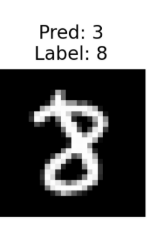
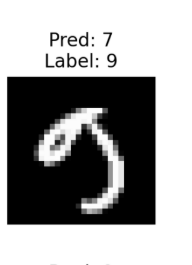


- **Direcții viitoare**:
  - Adăugarea regularizării (ex. `weight_decay` în optimizator) pentru a reduce supraînvățarea.
  - Experimentarea cu valori mai mari pentru `time_window` (ex. 50 sau 100) pentru a stabiliza codarea Poisson.
  - Analiza detaliată a erorilor cu o matrice de confuzie pentru a identifica clasele problematice.
